In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random
import multiprocessing
from dask import delayed, compute

In [2]:
#####a#####
df = pd.read_csv('data/Auto.csv')
# pd.set_option('display.max_rows', None)
df['horsepower']

0      130
1      165
2      150
3      150
4      140
      ... 
392     86
393     52
394     84
395     79
396     82
Name: horsepower, Length: 397, dtype: object

In [3]:
# df.dtypes
df = df[df['horsepower'] != '?']
df.shape

(392, 9)

In [4]:
m = df['mpg'].median()
df['mpg_high'] = (df['mpg'] >= m).astype(int)
df['orgn1'] = (df['origin'] == 1).astype(int)
df['orgn2'] = (df['origin'] == 2).astype(int)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,1,1,0
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,1,0,1
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,1,1,0
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,1,1,0


In [5]:
%%time

X = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 
        'year', 'orgn1', 'orgn2']]
y = df['mpg_high']
N = 100
mse_list = []

for i in range(N):
    random.seed(i)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                       y, test_size=0.35, random_state=i)
    LogReg = LogisticRegression(n_jobs=1, max_iter=1500)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    mse = ((y_test - y_pred) ** 2).mean()
    mse_list.append(mse)

avg_mse = sum(mse_list) / len(mse_list)
print('The average error rate is', avg_mse)

The average error rate is 0.10050724637681158
CPU times: user 2.79 s, sys: 15.3 ms, total: 2.81 s
Wall time: 3.03 s


In [6]:
#####b#####
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

Number of available cores is 8


In [ ]:
from dask.distributed import Client
client = Client(n_workers=8)

In [19]:
%%time

mse_list_parallel = []

def MSE(i, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                       y, test_size=0.35, random_state=i)
    LogReg = LogisticRegression(max_iter=1500)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    mse = ((y_test - y_pred) ** 2).mean()
    return mse

def avg(l):
    return sum(l) / len(l)

for i in range(N):
    mse = delayed(MSE)(i, X, y)
    mse_list_parallel.append(mse)

avg_mse_parallel = delayed(avg)(mse_list_parallel)
result = avg_mse_parallel.compute()
print('The average error rate is', result)

The average error rate is 0.10050724637681158
CPU times: user 773 ms, sys: 142 ms, total: 915 ms
Wall time: 2.17 s


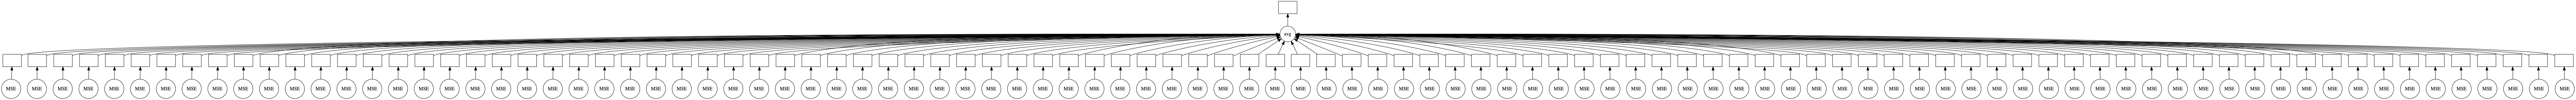

In [20]:
avg_mse_parallel.visualize()